<a href="https://colab.research.google.com/github/manchung/CS182_F23/blob/main/hw2_optimizer_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

If you are working on this assignment using Google Colab, please execute the codes below.

Alternatively, you can also do this assignment using a local anaconda environment (or a Python virtualenv). Please clone the GitHub repo by running `git clone https://github.com/Berkeley-CS182/cs182hw2.git` and refer to `README.md` for further details.

In [7]:
#@title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
#@title Set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cs182hw2_sp23'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs182hw2'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [11]:
#@title Install dependencies

!pip install numpy==1.21.6 imageio==2.9.0 matplotlib==3.2.2

In [9]:
#@title Clone homework repo

%cd $SYM_PATH
if not os.path.exists("cs182hw2"):
  !git clone https://github.com/Berkeley-CS182/cs182hw2.git
%cd cs182hw2

/content/gdrive/My Drive/cs182hw2_sp23
/content/gdrive/My Drive/cs182hw2_sp23/cs182hw2


In [10]:
#@title Download datasets

%cd deeplearning/datasets/
!bash ./get_datasets.sh
%cd ../..

/content/gdrive/MyDrive/cs182hw2_sp23/cs182hw2/deeplearning/datasets
--2023-12-20 04:08:57--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  52.0MB/s    in 3.3s    

2023-12-20 04:09:01 (49.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/gdrive/MyDrive/cs182hw2_sp23/cs182hw2


In [11]:
#@title Configure Jupyter Notebook

import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optimization Methods and Initizalization

Until now, you've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, you will learn more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result.

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this:
<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C2%20-%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Week%202/images/cost.jpg">
<caption><center> <u> <strong>Figure 1</strong> </u>: <strong>Minimizing the cost is like finding the lowest point in a hilly landscape<strong/><br> At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point. </center></caption>


In [12]:
# As usual, a bit of setup

import json
import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver
import random
import torch
seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [13]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [54]:
#@title fc_net.py

import math

import numpy as np

from deeplearning.layer_utils import *


class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3 * 32 * 32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-2, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # HW1: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian with standard deviation equal to   #
        # weight_scale, and biases should be initialized to zero. All weights and  #
        # biases should be stored in the dictionary self.params, with first layer  #
        # weights and biases using the keys 'W1' and 'b1' and second layer weights #
        # and biases using the keys 'W2' and 'b2'.                                 #
        ############################################################################
        self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dim)
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b2'] = np.zeros(num_classes)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # HW1: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        layer1_out, cache1 = affine_relu_forward(X, self.params['W1'], self.params['b1'])
        layer2_out, cache2 = affine_forward(layer1_out, self.params['W2'], self.params['b2'])
        scores = layer2_out
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # HW1: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization on the weights,    #
        # but not the biases.                                                      #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dout = softmax_loss(scores, y)
        loss += 0.5 * self.reg * (np.sum(self.params['W1'] ** 2)) + 0.5 * self.reg * (np.sum(self.params['W2'] ** 2))
        dout, grads['W2'], grads['b2'] = affine_backward(dout, cache2)
        _, grads['W1'], grads['b1'] = affine_relu_backward(dout, cache1)
        grads['W2'] += self.reg * self.params['W2']
        grads['W1'] += self.reg * self.params['W1']
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3 * 32 * 32, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None,
                 initialization='random'):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
          the network should not use dropout at all.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution with standard deviation equal to  #
        # weight_scale and biases should be initialized to zero in random          #
        # initialization.                                                          #
        # For He initialization, use fan_in mode assuming the activation is relu,  #
        # and initialize from a normal distribution.                               #
        ############################################################################
        dims = np.hstack((input_dim, hidden_dims, num_classes))
        for i in range(self.num_layers):
            if initialization == 'random':
                ############################################################################
                # TODO: YOUR CODE HERE                                                     #
                ############################################################################
                self.params['W%d' % (i + 1)] = weight_scale * np.random.randn(dims[i], dims[i+1])
                ############################################################################
                #                             END OF YOUR CODE                             #
                ############################################################################
            elif initialization == 'he':
                ############################################################################
                # TODO: YOUR CODE HERE                                                     #
                ############################################################################
                self.params['W%d' % (i + 1)] = np.sqrt(2/dims[i]) * np.random.randn(dims[i], dims[i+1])
                ############################################################################
                #                             END OF YOUR CODE                             #
                ############################################################################
            elif initialization == 'zero':
                ############################################################################
                # TODO: YOUR CODE HERE                                                     #
                ############################################################################
                self.params['W%d' % (i + 1)] = np.zeros((dims[i], dims[i+1]))
                ############################################################################
                #                             END OF YOUR CODE                             #
                ############################################################################
            self.params['b%d' % (i + 1)] = np.zeros(dims[i + 1])
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        scores = None
        ############################################################################
        # HW1: Implement the forward pass for the fully-connected net, computing   #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        ############################################################################
        scores, caches, reg_loss = X, [], 0
        for i in range(self.num_layers - 1):
            w, b = self.params['W%d' % (i + 1)], self.params['b%d' % (i + 1)]
            scores, cache = affine_relu_forward(scores, w, b)
            reg_loss += 0.5 * self.reg * np.sum(w ** 2)
            caches.append(cache)
        w, b = self.params['W%d' % (self.num_layers)], self.params['b%d' % (self.num_layers)]
        scores, cache = affine_forward(scores, w, b)
        reg_loss += 0.5 * self.reg * np.sum(w ** 2)
        caches.append(cache)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # HW1: Implement the backward pass for the fully-connected net. Store the  #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization on the         #
        # weights, but not the biases.                                             #
        #                                                                          #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dout = softmax_loss(scores, y)
        loss += reg_loss

        dout, dw, db = affine_backward(dout, caches.pop())
        grads['W%d' % (self.num_layers)] = dw + self.reg * w
        grads['b%d' % (self.num_layers)] = db

        for i in range(self.num_layers - 2, -1, - 1):
            dout, dw, db = affine_relu_backward(dout, caches.pop())
            w = self.params['W%d' % (i + 1)]
            grads['W%d' % (i + 1)] = dw + self.reg * w
            grads['b%d' % (i + 1)] = db
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


In [51]:
#@title Optim.py

import numpy as np

"""
This file implements various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""


def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    #############################################################################
    # TODO: Implement the momentum update formula. Store the updated value in   #
    # the next_w variable. You should also use and update the velocity v.       #
    #############################################################################
    # raise NotImplementedError()
    learning_rate = config['learning_rate']
    momentum = config['momentum']

    v = momentum * v + dw
    next_w = w - learning_rate * v
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    config['velocity'] = v

    return next_w, config


def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared gradient
    values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('decay_rate', 0.99)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('cache', np.zeros_like(w))

    next_w = None
    #############################################################################
    # TODO: Implement the RMSprop update formula, storing the next value of x   #
    # in the next_w variable. Don't forget to update cache value stored in      #
    # config['cache'].                                                          #
    #############################################################################
    # raise NotImplementedError()
    learning_rate = config['learning_rate']
    decay_rate = config['decay_rate']
    epsilon = config['epsilon']

    config['cache'] = decay_rate * config['cache'] + (1 - decay_rate) * dw * dw
    next_w = w - learning_rate * dw / (np.sqrt(config['cache']) + epsilon)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return next_w, config


def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    next_w = None
    #############################################################################
    # TODO: Implement the Adam update formula, storing the next value of x in   #
    # the next_w variable. Don't forget to update the m, v, and t variables     #
    # stored in config.                                                         #
    #############################################################################
    # raise NotImplementedError()
    config['t'] += 1
    config['m'] = config['beta1'] * config['m'] + (1 - config['beta1']) * dw
    config['v'] = config['beta2'] * config['v'] + (1 - config['beta2']) * dw ** 2
    m_corrected = config['m'] / (1 - np.power(config['beta1'], config['t']))
    v_corrected = config['v'] / (1 - np.power(config['beta2'], config['t']))

    next_w = w - config['learning_rate'] * m_corrected / \
        (np.sqrt(v_corrected) + config['epsilon'])
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return next_w, config



#############################################################################
# Solution for RMSProp:
#############################################################################
# cache = config['decay_rate'] * config['cache'] + (1 - config['decay_rate']) * (dw ** 2)
# next_w = w - config['learning_rate'] * dw / (np.sqrt(cache) + config['epsilon'])
# config['cache'] = cache

class Optim:
  def __init__(self):
    self.sgd = sgd
    self.sgd_momentum = sgd_momentum
    self.rmsprop = rmsprop
    self.adam = adam

optim = Optim()

In [48]:
# Test RMSProp implementation; you should see errors less than 1e-7.
# from deeplearning.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  0.004151355119843246
cache error:  0.22969837587006955


In [32]:
#@title solver.py

import numpy as np

# from deeplearning import optim


class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various optoins (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists containing
    the accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'X_train': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and return
      a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data with the following:
          'X_train': Array of shape (N_train, d_1, ..., d_k) giving training images
          'X_val': Array of shape (N_val, d_1, ..., d_k) giving validation images
          'y_train': Array of shape (N_train,) giving labels for training images
          'y_val': Array of shape (N_val,) giving labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the learning
          rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)
        self.log_acc_iteration = kwargs.pop('log_acc_iteration', False)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in kwargs.keys())
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.log_acc_iteration_history = []
        self.log_grad_norm_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

        #############################################################################
        # TODO: Store the mean of l2 norm of each gradient in log_grad_norm_history #
        #############################################################################
        all_grads = np.hstack([g.flatten() for g in grads.values()])
        mean_grad_l2 = np.mean(all_grads**2)
        self.log_grad_norm_history.append(mean_grad_l2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def record_histories_as_npz(self, filename):
        tl_hist = np.array(self.loss_history)
        ta_hist = np.array(self.train_acc_history)
        va_hist = np.array(self.val_acc_history)
        np.savez(filename, train_losses=tl_hist, train_accs=ta_hist, val_accs=va_hist)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay the
            # learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations + 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                                                num_samples=1000)
                val_acc = self.check_accuracy(self.X_val, self.y_val)
                if self.log_acc_iteration:
                    self.log_acc_iteration_history.append(t)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                        self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params


## 1 - Stochastic Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent.

A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent.

In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this:

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C2%20-%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Week%202/images/kiank_sgd.png">
<caption><center> <u>  <strong>Figure 1</strong> </u> : <strong>SGD vs GD</strong><br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>

In the following code snippet, we will use SGD to optimze a five-layer FullyConnectedNet so that it overfits to 50 training exmaples.

(Iteration 1 / 40) loss: 128.055274
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.146000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.092000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.098000


/content/gdrive/MyDrive/cs182hw2_sp23/cs182hw2/deeplearning/layers.py:153: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch 3 / 20) train acc: 0.780000; val_acc: 0.098000
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.095000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.104000
(Iteration 11 / 40) loss: 2.708025
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.089000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.090000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.106000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.102000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.103000
(Iteration 21 / 40) loss: 0.055889
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.101000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.109000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.109000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.104000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.104000
(Iteration 31 / 40) loss: 0.000038
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.104000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.104000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.104000
(Epoch 19 / 20) train 

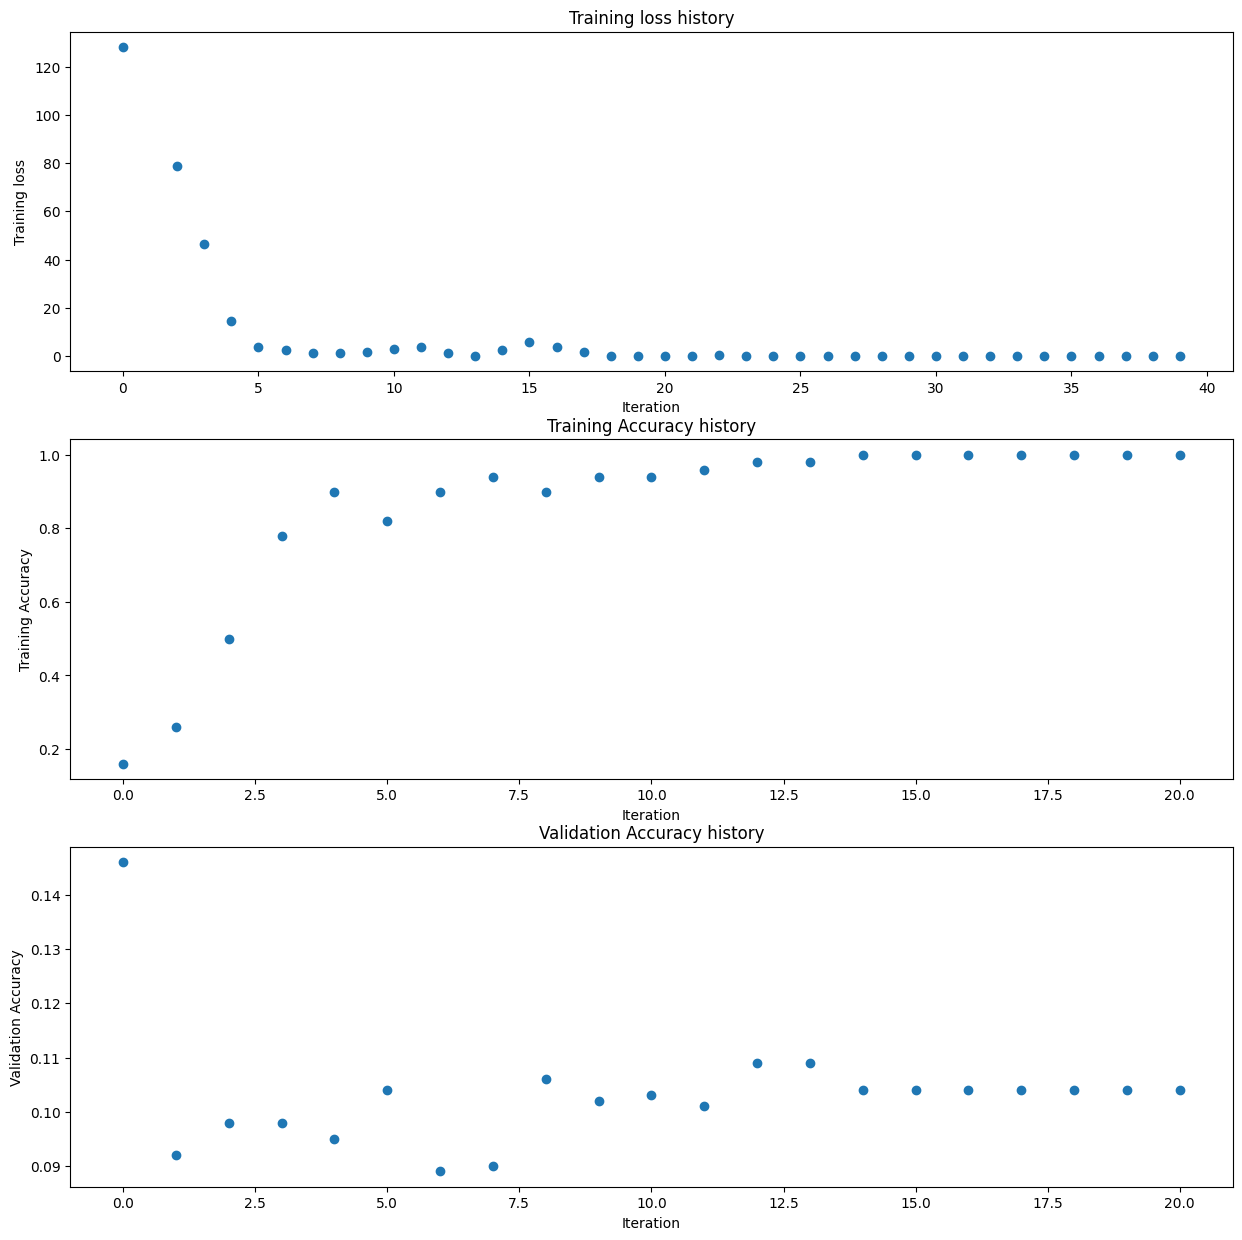

In [33]:
## Use a five-layer Net to overfit 50 training examples.


num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)

solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, 'o')
plt.title('Training Accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Training Accuracy')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, 'o')
plt.title('Validation Accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.gcf().set_size_inches(15, 15)

plt.show()

## 2 - Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

<img src="https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C2%20-%20Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Week%202/images/opt_momentum.png">
<caption><center> <u><strong>Figure 3</strong></u>: The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence v (velocity) and then take a step in the direction of v.<br> </center>

 The momentum update rule for a weight matrix w is:

$$ \begin{cases}
v_{dw}^t = m * v_{dw}^{(t-1)} + dw\\
{w} = w - \alpha  v_{dw}^t
\end{cases}\tag{3}$$


where $m$ is the momentum and $\alpha$ is the learning rate. Note that the iterator `t` starts at 1.

Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent, it can be viewed conceptually a larger "effective batch size" versus vanilla stochastic gradient descent.

Open the file `deeplearning/optim.py` and read the documentation at the top of the file to make sure you understand the API. **Implement the SGD+momentum update rule** in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-7.

In [28]:
# from deeplearning.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
 [-0.39994, -0.347375263, -0.294810526, -0.242245789, -0.189681053],
 [-0.137116316, -0.084551579, -0.031986842, 0.020577895, 0.073142632],
 [0.125707368, 0.178272105, 0.230836842, 0.283401579, 0.335966316],
 [0.388531053, 0.441095789, 0.493660526, 0.546225263, 0.59879]])
expected_velocity = np.asarray([
 [-0.06, 0.006842105, 0.073684211, 0.140526316, 0.207368421],
 [0.274210526, 0.341052632, 0.407894737, 0.474736842, 0.541578947],
 [0.608421053, 0.675263158, 0.742105263, 0.808947368, 0.875789474],
 [0.942631579, 1.009473684, 1.076315789, 1.143157895, 1.21]
])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  6.3941900171621575e-09
velocity error:  1.923077600561035e-08


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge a bit faster.

running with  sgd
(Iteration 1 / 200) loss: 2.897756
(Epoch 0 / 5) train acc: 0.109000; val_acc: 0.127000
(Iteration 11 / 200) loss: 2.186901
(Iteration 21 / 200) loss: 2.166857
(Iteration 31 / 200) loss: 2.106118
(Epoch 1 / 5) train acc: 0.285000; val_acc: 0.256000
(Iteration 41 / 200) loss: 1.957846
(Iteration 51 / 200) loss: 1.931837
(Iteration 61 / 200) loss: 1.762598
(Iteration 71 / 200) loss: 1.896026
(Epoch 2 / 5) train acc: 0.347000; val_acc: 0.288000
(Iteration 81 / 200) loss: 1.898440
(Iteration 91 / 200) loss: 1.891966
(Iteration 101 / 200) loss: 1.688747
(Iteration 111 / 200) loss: 1.819004
(Epoch 3 / 5) train acc: 0.351000; val_acc: 0.281000
(Iteration 121 / 200) loss: 1.891634
(Iteration 131 / 200) loss: 1.781320
(Iteration 141 / 200) loss: 1.792184
(Iteration 151 / 200) loss: 1.736709
(Epoch 4 / 5) train acc: 0.369000; val_acc: 0.319000
(Iteration 161 / 200) loss: 1.562923
(Iteration 171 / 200) loss: 1.604270
(Iteration 181 / 200) loss: 1.643578
(Iteration 191 / 200) los

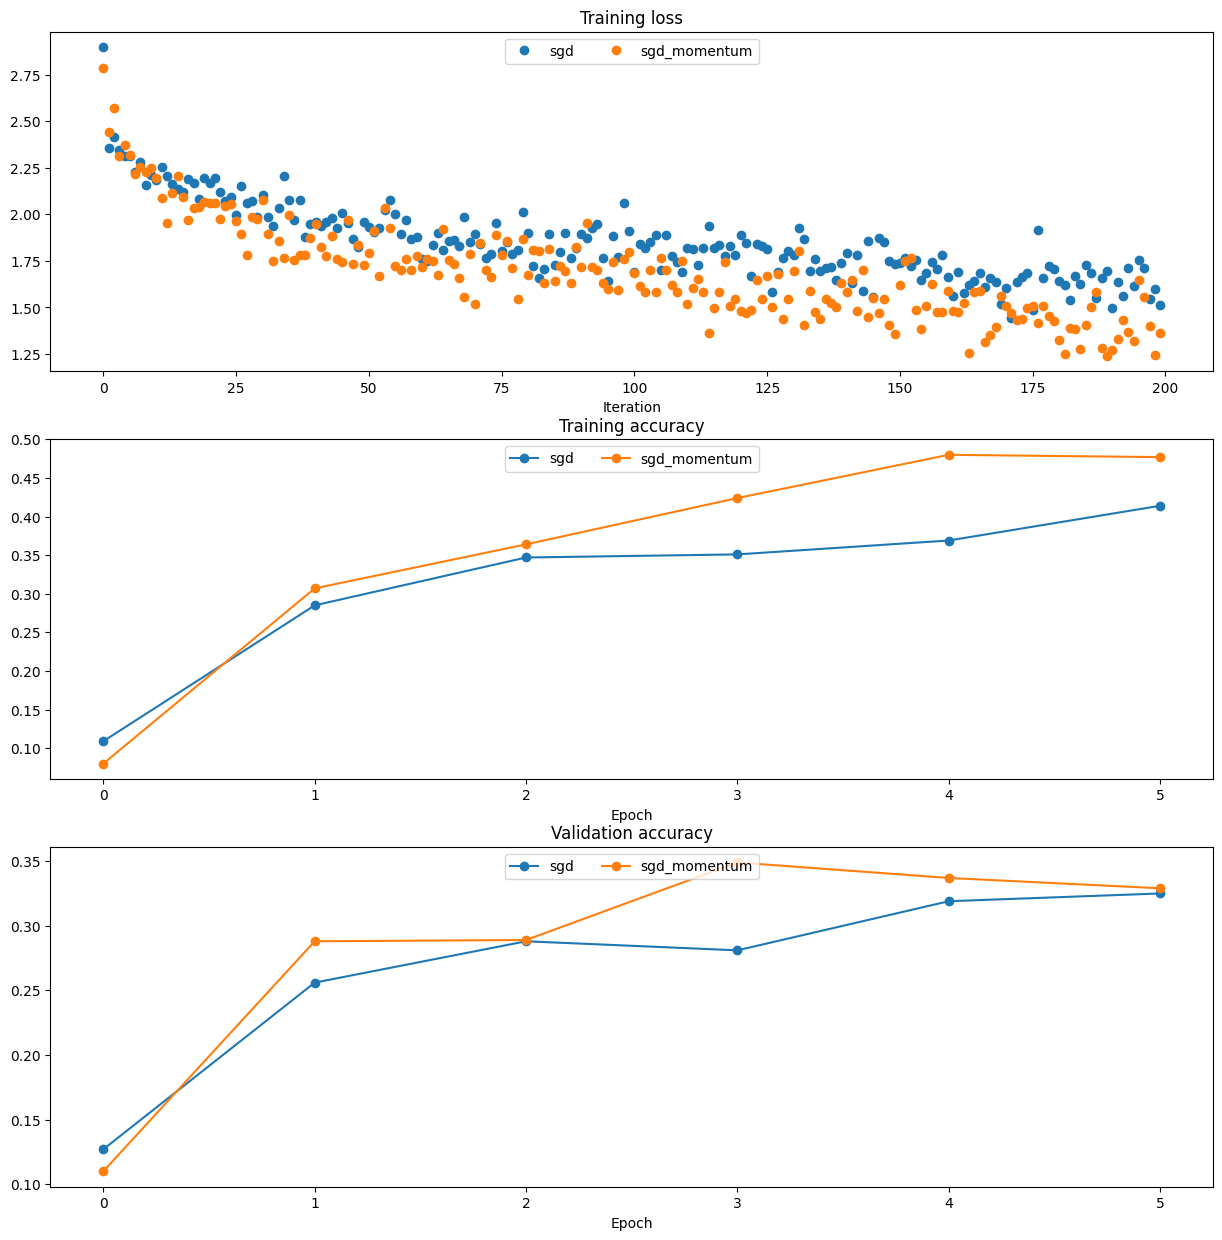

In [34]:
#@title SGD vs SGD+Momentum
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    os.makedirs("submission_logs", exist_ok=True)
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

A further step: as we discussed above, we can see how SGD+Momentum is conceptually giving you a larger "effective batch size" by increase the batch size used in the SGD above. In this way, SGD+Momentum can significantly speed up training.

**Tune the batch size for plain SGD** so that the training accuracy is similar to that of SGD with momentum. The average accuracy difference between them should be less than `0.04`. The accuracy is averaged over three different random seeds for better stability.

running with sgd  ; seed = 300
(Iteration 1 / 300) loss: 2.615600
(Epoch 0 / 50) train acc: 0.101000; val_acc: 0.095000
(Epoch 1 / 50) train acc: 0.157000; val_acc: 0.159000
(Iteration 11 / 300) loss: 2.214672
(Epoch 2 / 50) train acc: 0.173000; val_acc: 0.173000
(Epoch 3 / 50) train acc: 0.216000; val_acc: 0.207000
(Iteration 21 / 300) loss: 2.134047
(Epoch 4 / 50) train acc: 0.239000; val_acc: 0.230000
(Epoch 5 / 50) train acc: 0.262000; val_acc: 0.242000
(Iteration 31 / 300) loss: 2.043973
(Epoch 6 / 50) train acc: 0.275000; val_acc: 0.259000
(Iteration 41 / 300) loss: 1.977884
(Epoch 7 / 50) train acc: 0.269000; val_acc: 0.276000
(Epoch 8 / 50) train acc: 0.299000; val_acc: 0.298000
(Iteration 51 / 300) loss: 1.951424
(Epoch 9 / 50) train acc: 0.320000; val_acc: 0.282000
(Epoch 10 / 50) train acc: 0.317000; val_acc: 0.303000
(Iteration 61 / 300) loss: 1.892340
(Epoch 11 / 50) train acc: 0.272000; val_acc: 0.295000
(Iteration 71 / 300) loss: 1.905495
(Epoch 12 / 50) train acc: 0.349

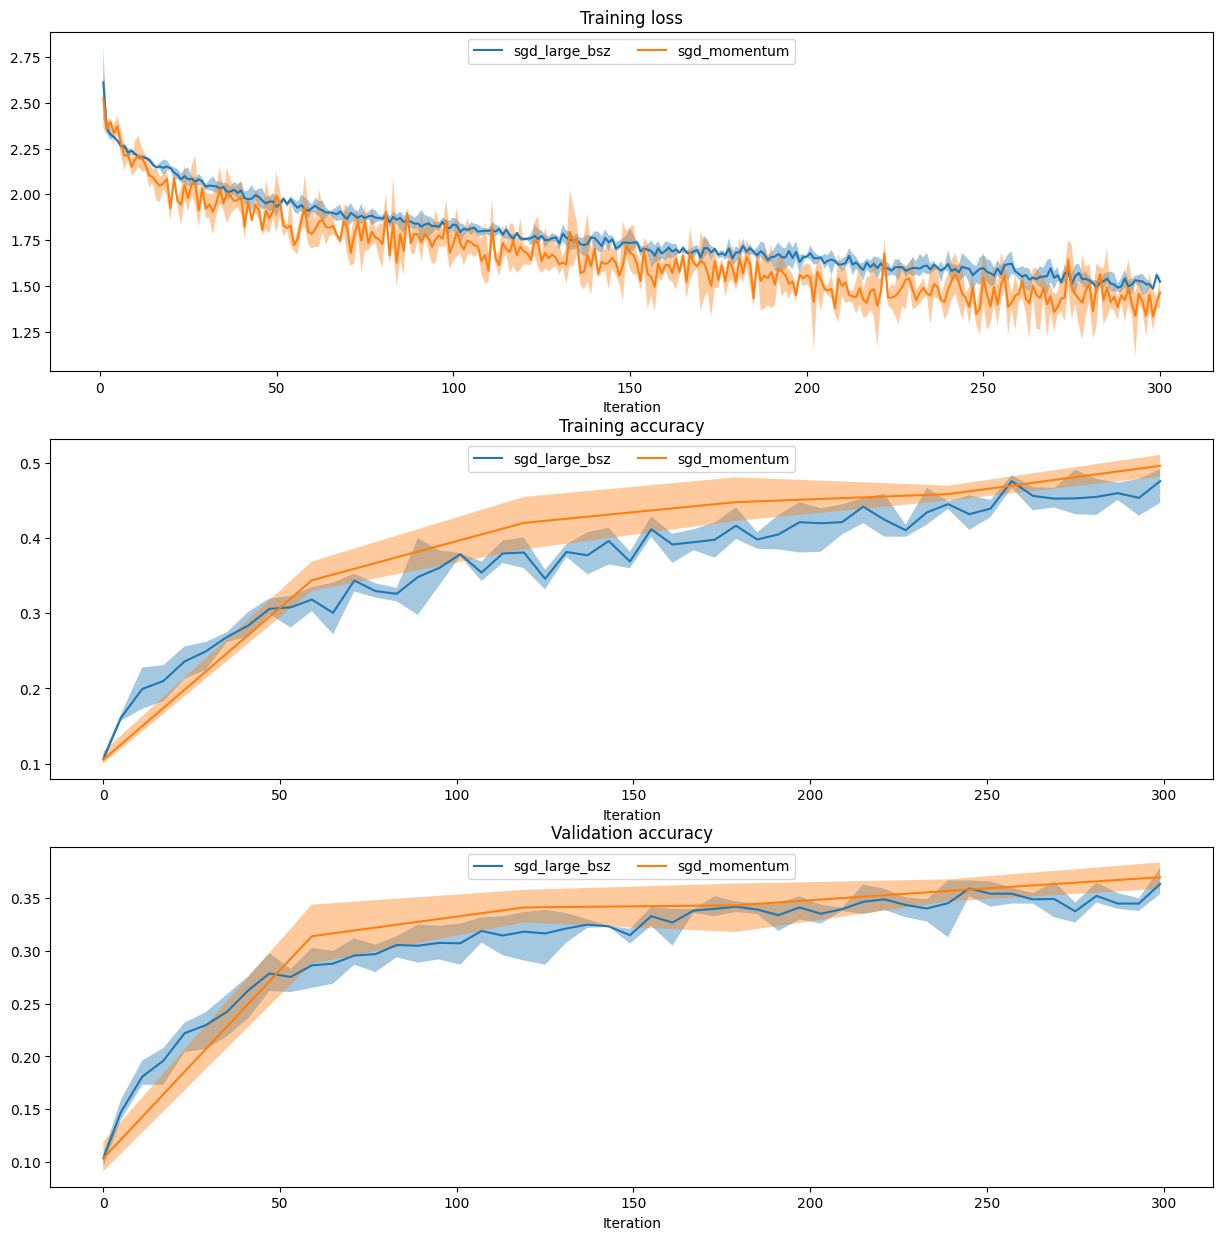

In [37]:
#############################################################################
# TODO: Tune the batch size for the SGD below until you observe             #
# similar end of iteration training performance.                            #
# It means rel_error(train_acc) < 0.04                                      #
#############################################################################
batch_sizes = {
  'sgd_momentum': 100,
  'sgd': 1000,  # tune the batch size of SGD (must be multiples of 100)
}

num_train = 6000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
total_acc = {}

labels = {
  'sgd_momentum': 'sgd_momentum',
  'sgd': 'sgd_large_bsz',
}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with', update_rule, ' ; seed =', seed)
    # set the epochs so that we have the same number of steps for both rules
    training_epochs = 5 * int(batch_sizes[update_rule]/100)
    solvers[update_rule] = {}
    total_acc[update_rule] = 0

    for seed in [100, 200, 300]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

        solver = Solver(
            model, small_data,
            num_epochs=training_epochs,
            batch_size=batch_sizes[update_rule],
            update_rule=update_rule,
            optim_config={
                'learning_rate': 1e-2,  # please do not change the learning rate
            },
            verbose=True,
            log_acc_iteration=True)

        solvers[update_rule][seed] = solver
        solver.train()
        solver.record_histories_as_npz(
            "submission_logs/sgd_momentum_compare_{}_{}"
            .format(update_rule, seed)
        )

        total_acc[update_rule] += solvers[update_rule][seed].train_acc_history[-1]

print('Average Training Acc for sgd:', total_acc['sgd'] / 3)
print('Average Training Acc for sgd_momentum:', total_acc['sgd_momentum'] / 3)
print('Train Acc Difference: ',
       rel_error(total_acc['sgd'] / 3,
                 total_acc['sgd_momentum'] / 3))

def plot_solver_seeds(solver_s, x_field, y_field, seeds, label):
    a = np.array([getattr(solver_s[seed], y_field) for seed in seeds])
    if x_field is None:
        plt_x = np.arange(a.shape[1]) + 1
    else:
        plt_x = getattr(solver_s[seeds[0]], x_field)
    plt.plot(plt_x, a.mean(axis=0), label=label)
    plt.fill_between(plt_x, a.min(axis=0), a.max(axis=0), alpha=0.4)

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Iteration')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Iteration')

for update_rule, solver_s in solvers.items():
    plt.subplot(3, 1, 1)
    # plt.plot(solver.loss_history, 'o', label=labels[update_rule])
    plot_solver_seeds(solver_s, None, 'loss_history',
                      [100, 200, 300], labels[update_rule])

    plt.subplot(3, 1, 2)
    # plt.plot(solver.log_acc_iteration_history, solver.train_acc_history, '-o', label=labels[update_rule])
    plot_solver_seeds(solver_s, 'log_acc_iteration_history', 'train_acc_history',
                      [100, 200, 300], labels[update_rule])

    plt.subplot(3, 1, 3)
    # plt.plot(solver.log_acc_iteration_history, solver.val_acc_history, '-o', label=labels[update_rule])
    plot_solver_seeds(solver_s, 'log_acc_iteration_history', 'val_acc_history',
                      [100, 200, 300], labels[update_rule])

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()


## 3 - Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp and Momentum.

<strong>How does Adam work?<strong>
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $m^{corrected}$ (with bias correction).
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $v^{corrected}$ (with bias correction).
3. It updates parameters in a direction based on combining information from "1" and "2".

$$\begin{cases}
m_{dw} = \beta_1 m_{dw} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W } \\
m^{corrected}_{dw} = \frac{m_{dw}}{1 - (\beta_1)^t} \\
v_{dw} = \beta_2 v_{dw} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W })^2 \\
v^{corrected}_{dw} = \frac{v_{dw}}{1 - (\beta_2)^t} \\
w = w - \alpha \frac{m^{corrected}_{dw}}{\sqrt{v^{corrected}_{dw}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages.
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero




RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `deeplearning/optim.py`, **implement the RMSProp update rule** in the `rmsprop` function (optional, the solution is provided at the bottom of optim.py) and **implement the Adam update rule** in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [50]:
# Test RMSProp implementation; you should see errors less than 1e-7.
# from deeplearning.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [52]:
# Test Adam implementation; you should see errors around 1e-7 or less.
# from deeplearning.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])
expected_t = 6

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('v error: ', rel_error(expected_v, config['v']))
print ('m error: ', rel_error(expected_m, config['m']))
print ('t error: ', rel_error(expected_t, config['t']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09
t error:  0.0


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules. As a sanity check, you should see that RMSProp and Adam typically obtain at least 45% training accuracy within 5 epochs.

running with  sgd
(Iteration 1 / 200) loss: 2.920601
(Epoch 0 / 5) train acc: 0.095000; val_acc: 0.106000
(Iteration 11 / 200) loss: 2.259420
(Iteration 21 / 200) loss: 2.259472
(Iteration 31 / 200) loss: 2.111666
(Epoch 1 / 5) train acc: 0.265000; val_acc: 0.249000
(Iteration 41 / 200) loss: 2.049079
(Iteration 51 / 200) loss: 2.008793
(Iteration 61 / 200) loss: 1.969929
(Iteration 71 / 200) loss: 2.015482
(Epoch 2 / 5) train acc: 0.342000; val_acc: 0.323000
(Iteration 81 / 200) loss: 1.877204
(Iteration 91 / 200) loss: 1.746421
(Iteration 101 / 200) loss: 1.820583
(Iteration 111 / 200) loss: 1.814485
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.315000
(Iteration 121 / 200) loss: 1.839074
(Iteration 131 / 200) loss: 1.712924
(Iteration 141 / 200) loss: 1.834413
(Iteration 151 / 200) loss: 1.771377
(Epoch 4 / 5) train acc: 0.431000; val_acc: 0.332000
(Iteration 161 / 200) loss: 1.707295
(Iteration 171 / 200) loss: 1.539645
(Iteration 181 / 200) loss: 1.492332
(Iteration 191 / 200) los

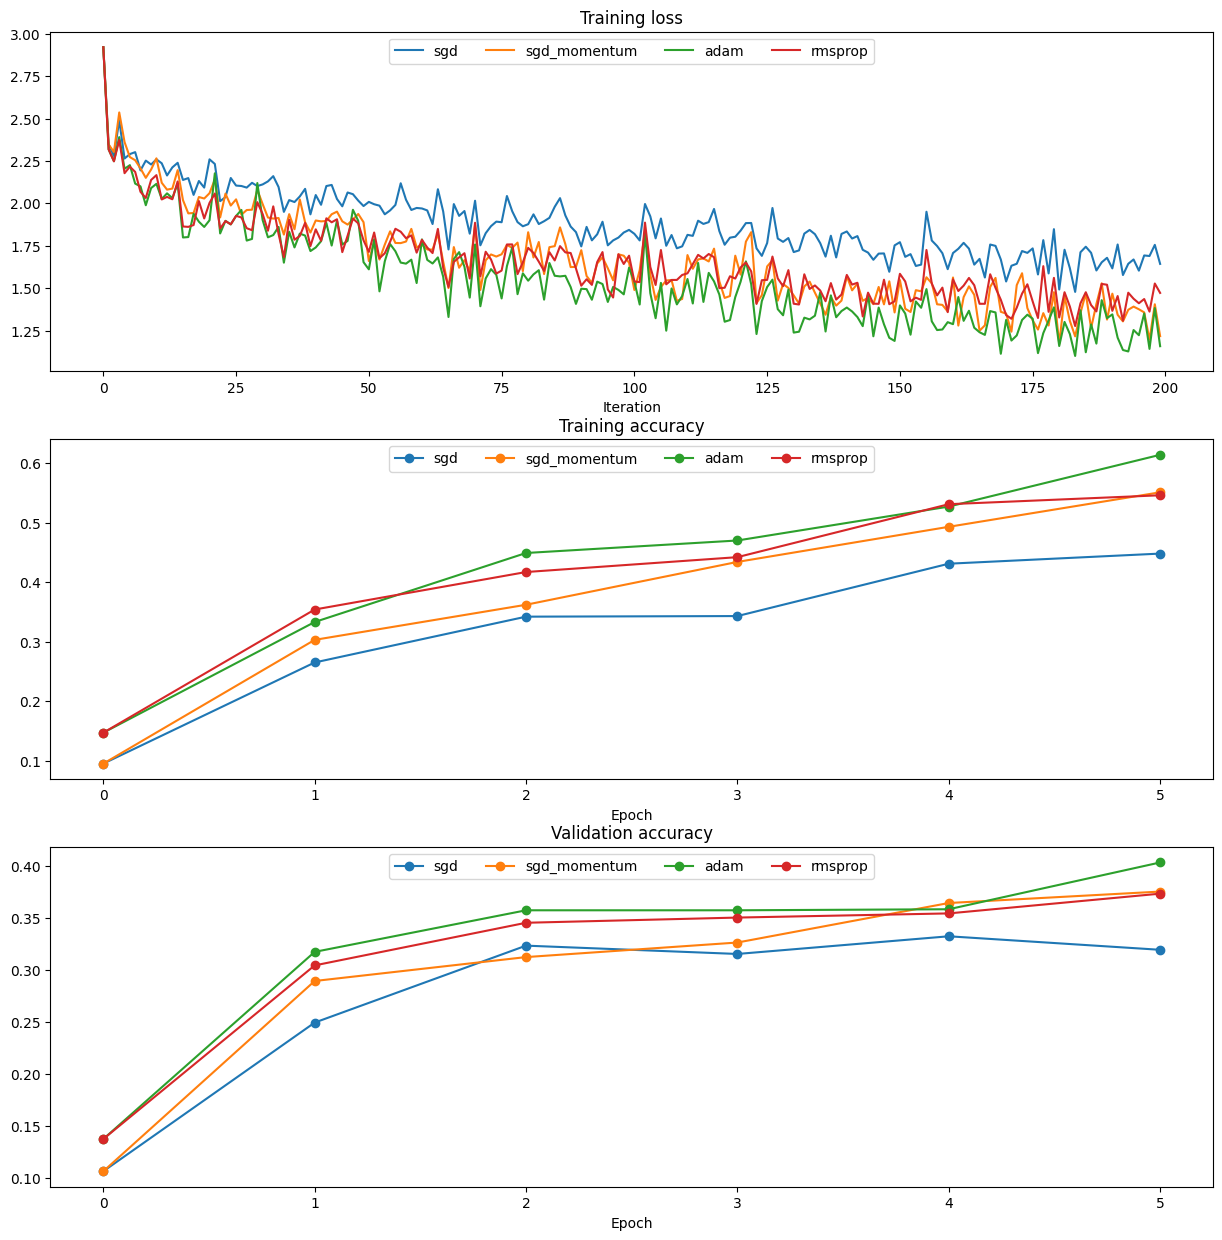

In [53]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3, 'sgd': 1e-2, 'sgd_momentum': 1e-2}
for update_rule in ['sgd', 'sgd_momentum', 'adam', 'rmsprop']:
    print ('running with ', update_rule)

    torch.manual_seed(0)
    np.random.seed(0)

    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True,)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Initialization

Training your neural network requires specifying an initial value of the weights. A well chosen initialization method will help learning.  


A well chosen initialization can:
- Speed up the convergence of gradient descent
- Increase the odds of gradient descent converging to a lower training (and generalization) error

We will use three different initilization methods to illustrate this concept.

- Zero Initialization:

    This initializes the weights to 0.


- Random Initialization:

    This initializes the weights drawn from a distribution with *manually* specified scales. In this homework, **we use normal distribution with the `weight_scale` argument in `fc_net.py` as its std.**

- He/Xavier/Glorot Initialization:

    This is a special case for random initialization, where the scaling factor is set so that the std of each parameter is `gain / sqrt(fan_mode)`. `gain` is determined by the activation function. For example, linear activation has `gain = 1` and ReLU activation has `gain = sqrt(2)`. There are three types of fan mode:
    - Fan in: `fan_mode = in_dim`, i.e., the width of the preceding layer, preserving the magnitude in forward pass. **This is what you need to implement below** and also the default in PyTorch.
    - Fan out: `fan_mode = out_dim`, i.e., the width of the succeeding layer, preserving the magnitude in backpropagation.
    - Average: `fan_mode = (in_dim + out_dim) / 2`.

    When the std is determined, another choice is between normal distribution or uniform distribution. In this homework **we use normal distribution for initialization.**

running with  sgd
initialization scheme: he
Layer 1, rel_error 1.903445941569443e-05
Layer 2, rel_error 0.001928263065996156
(Iteration 1 / 200) loss: inf
(Epoch 0 / 5) train acc: 0.088000; val_acc: 0.096000
(Iteration 11 / 200) loss: 11.058469


/content/gdrive/MyDrive/cs182hw2_sp23/cs182hw2/deeplearning/layers.py:153: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Iteration 21 / 200) loss: 4.772619
(Iteration 31 / 200) loss: 4.545839
(Epoch 1 / 5) train acc: 0.133000; val_acc: 0.136000
(Iteration 41 / 200) loss: 2.965914
(Iteration 51 / 200) loss: 2.957076
(Iteration 61 / 200) loss: 3.045602
(Iteration 71 / 200) loss: 2.488957
(Epoch 2 / 5) train acc: 0.152000; val_acc: 0.144000
(Iteration 81 / 200) loss: 3.272993
(Iteration 91 / 200) loss: 2.669181
(Iteration 101 / 200) loss: 2.506165
(Iteration 111 / 200) loss: 2.273517
(Epoch 3 / 5) train acc: 0.197000; val_acc: 0.170000
(Iteration 121 / 200) loss: 2.468692
(Iteration 131 / 200) loss: 2.288861
(Iteration 141 / 200) loss: 2.287873
(Iteration 151 / 200) loss: 2.150057
(Epoch 4 / 5) train acc: 0.207000; val_acc: 0.162000
(Iteration 161 / 200) loss: 2.360841
(Iteration 171 / 200) loss: 2.291984
(Iteration 181 / 200) loss: 2.180932
(Iteration 191 / 200) loss: 2.192476
(Epoch 5 / 5) train acc: 0.235000; val_acc: 0.158000
running with  sgd
initialization scheme: random
Layer 1, rel_error 0.00016643

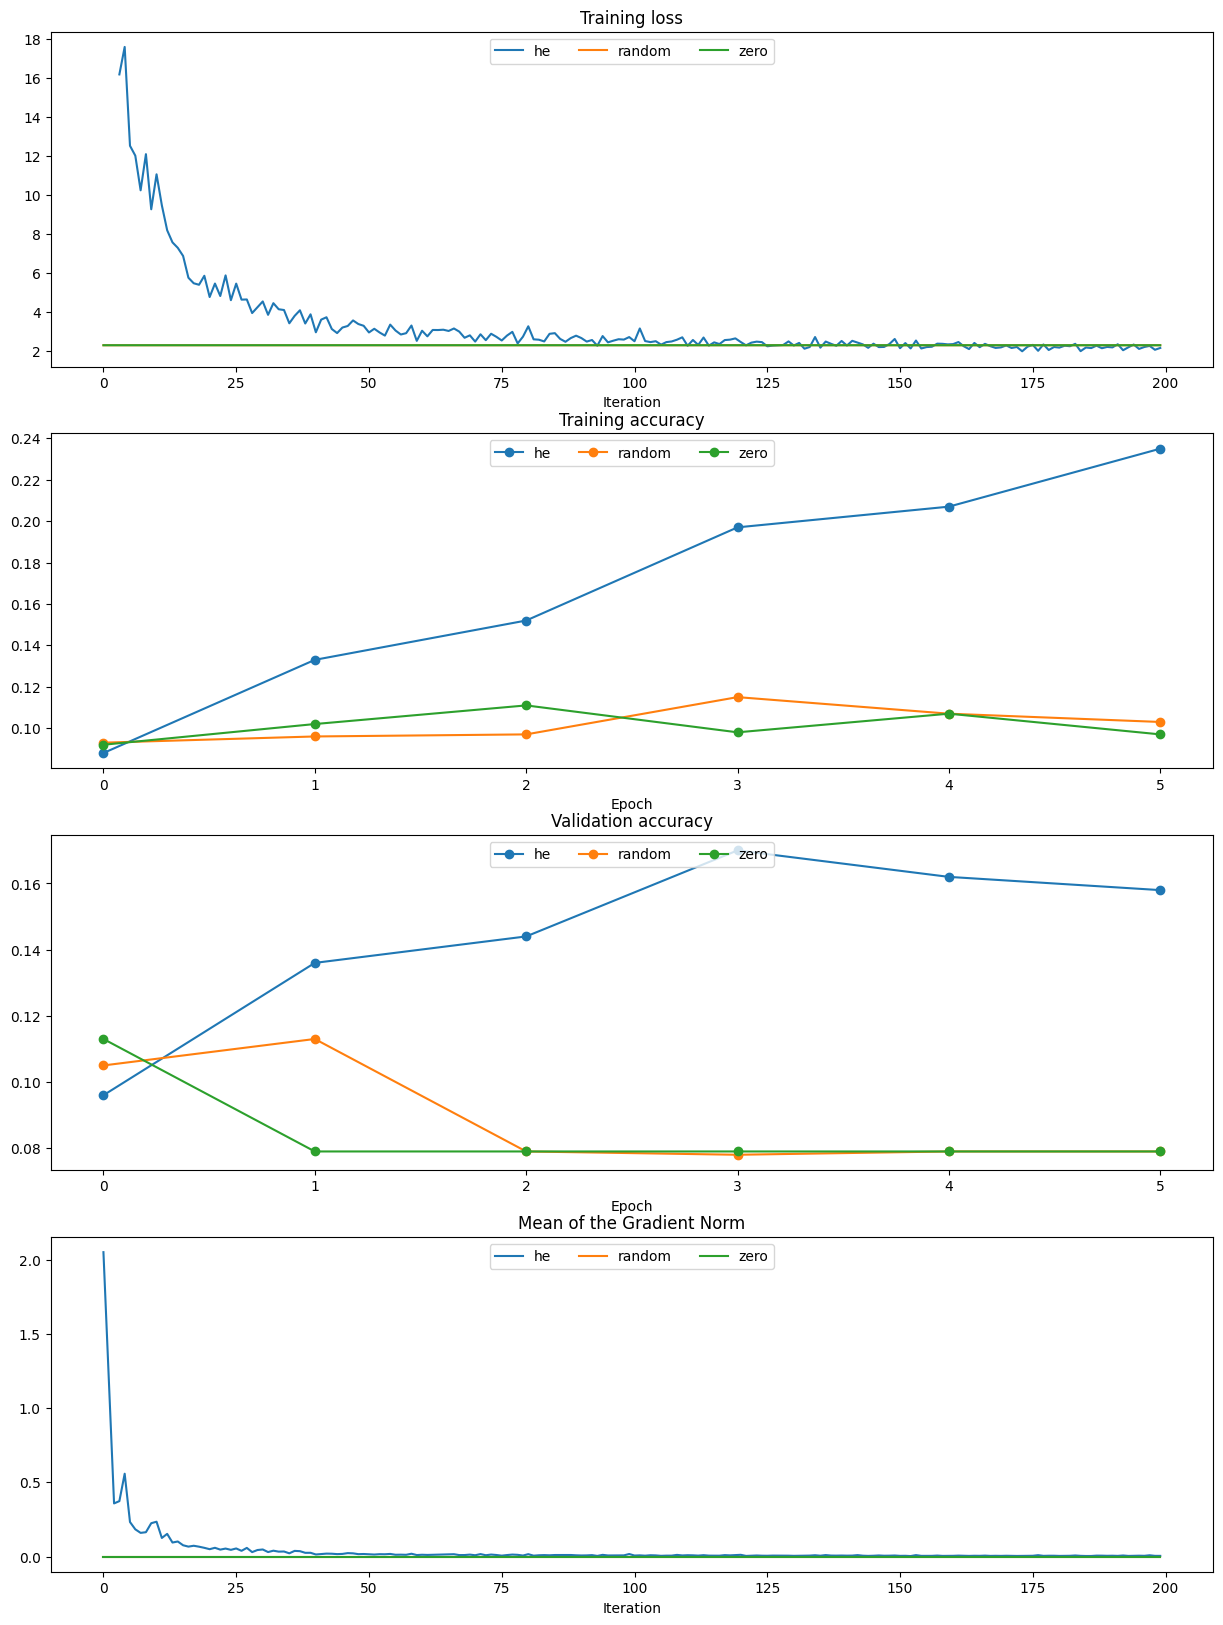

In [55]:
#############################################################################
# TODO:
# 1. implement three initialization schemes in
#    deeplearning/classifiers/fc_net.py
# 2. record the mean of l2 norm of the gradients
#    in the deeplearning/solver.py
#############################################################################

learning_rates = {'sgd': 1e-3}
update_rule = 'sgd'
solvers = dict()

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

for initialization in ['he', 'random', 'zero']:
    print ('running with ', update_rule)

    model = FullyConnectedNet([50]*10, initialization=initialization)
    weight_stds = [float(model.params["W" + str(i)].std()) for i in range(1, 12)]
    print("initialization scheme:", initialization)
    if initialization == "he":
        # It is fine if the rel_error is less than 0.03 due to randomness
        print("Layer 1, rel_error", rel_error(0.02551551815399, weight_stds[0]))
        print("Layer 2, rel_error", rel_error(0.2, weight_stds[1]))
    elif initialization == "random":
        # It is fine if the rel_error is less than 0.03 due to randomness
        print("Layer 1, rel_error", rel_error(0.01, weight_stds[0]))
        print("Layer 2, rel_error", rel_error(0.01, weight_stds[1]))
    with open("submission_logs/w_stds_{}.json".format(initialization), "w", encoding="utf-8") as f:
        json.dump(weight_stds, f)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[initialization] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/initialization_experiment_{}".format(initialization))
    print

plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')


plt.subplot(4, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Mean of the Gradient Norm')
plt.xlabel('Iteration')

for initialization, solver in solvers.items():
    plt.subplot(4, 1, 1)
    plt.plot(solver.loss_history, label=initialization)

    plt.subplot(4, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=initialization)

    plt.subplot(4, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=initialization)

    plt.subplot(4, 1, 4)
    plt.plot(solver.log_grad_norm_history, label=initialization)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 20)

plt.show()

### Question:

**What you observe in the mean of gradient norm plot above in the above plots?** Try to give an explanation. **Write your answer on the written assignment.**

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable and the solver used in the `best_solver` variable. We require you to get at least 45% accuracy *on the validation set* using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

In [ ]:
best_model = None
best_solver = None


width = 200  # please don't change this
n_layers = 10  # please don't change this

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10.             #
# Store your best model in the best_model variable                             #
# and the solver used to train it in the best_solver variable                  #
# Please use the He Initialization and adam.                                   #
# You could tune the following variables only below,                           #
# it shoud achieve above 45% accuracy on the validation set.                   #
################################################################################
lr = ?
num_epochs = ?
batch_size = ?
lr_decay = ?
update_rule = ?
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

np.random.seed(2023)  # please don't change this for reproducibility
torch.manual_seed(2023)  # please don't change this for reproducibility
model = FullyConnectedNet([width] * n_layers,
                          initialization='he'
                          )
solver = Solver(model,
                data,
                num_epochs=num_epochs,
                batch_size=batch_size,
                update_rule=update_rule,
                optim_config={
                  'learning_rate': lr
                },
                lr_decay=lr_decay,
                verbose=True)
solver.train()
best_model = model
best_solver = solver

# Test your model
Run your best model on the validation and test sets and record the training logs of the best solver. You should achieve above 45% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
val_acc = (y_val_pred == data['y_val']).mean()
test_acc = (y_test_pred == data['y_test']).mean()
print ('Validation set accuracy: ', val_acc)
print ('Test set accuracy: ', test_acc)
best_solver.record_histories_as_npz('submission_logs/best_fc_model.npz')
import json
with open("submission_logs/results.json", "w", encoding="utf-8") as f:
    json.dump(dict(
        val_acc = val_acc,
        test_acc = test_acc,
        lr = lr,
        num_epochs = num_epochs,
        batch_size = batch_size,
        lr_decay = lr_decay,
        update_rule = update_rule
    ), f)

# Collect your submissions

On Colab, after running the following cell, you can download your submissions from the `Files` tab, which can be opened by clicking the file icon on the left hand side of the screen.

In [ ]:
!rm -f cs182hw2_submission.zip
!zip -r cs182hw2_submission.zip . -x "*.git*" "*deeplearning/datasets*" "*.ipynb_checkpoints*" "*README.md" ".env/*" "*.pyc" "*deeplearning/build/*" "*__pycache__/*"